In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train_df = pd.read_csv('../../data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv', index_col='session_id')

In [3]:
sites = ['site%s' % i for i in range(1, 11)]
times = ['time%s' % i for i in range(1, 11)]

train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

train_df = train_df.sort_values(by='time1')

with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

In [4]:
graph_train = train_df.copy()
graph_train['start_time'] = [d.hour for d in graph_train['time1']]

In [5]:
graph_train['weekday'] = [d.weekday() for d in graph_train['time1']]

In [6]:
graph_train['year_month'] = [str(d.year) +str(d.month) if d.month >= 10 
                             else str(d.year) + '0' + str(d.month) for d in graph_train['time1']]

In [8]:
graph_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site8,time8,site9,time9,site10,time10,target,start_time,weekday,year_month
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,0,8,5,201301
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,0,8,5,201301
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0,8,5,201301
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0,8,5,201301
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0,8,5,201301


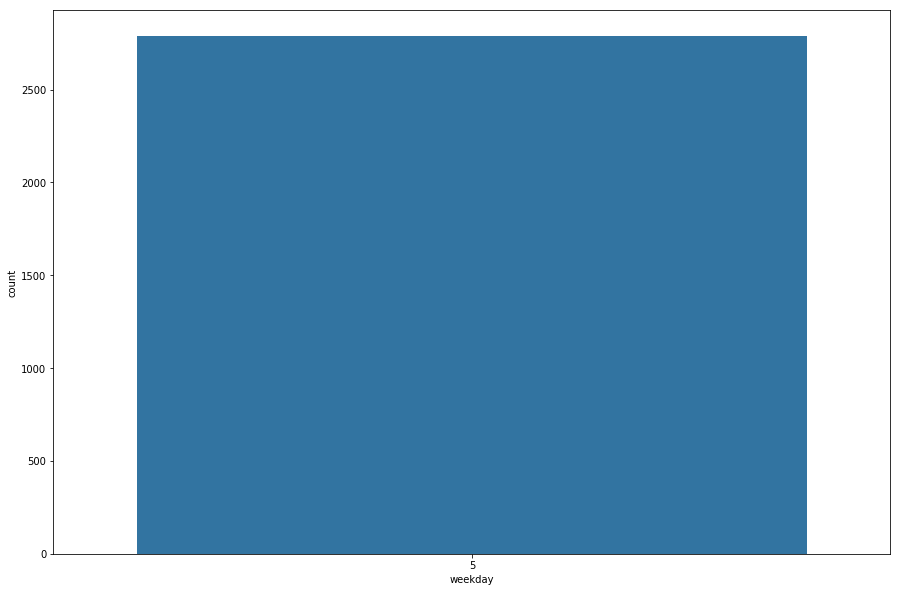

In [39]:
data = graph_train[(graph_train['year_month'] == '201310') & (graph_train['target'] == 0)]
plt.figure(figsize=(15,10))
sns.countplot(x='weekday', data=data);

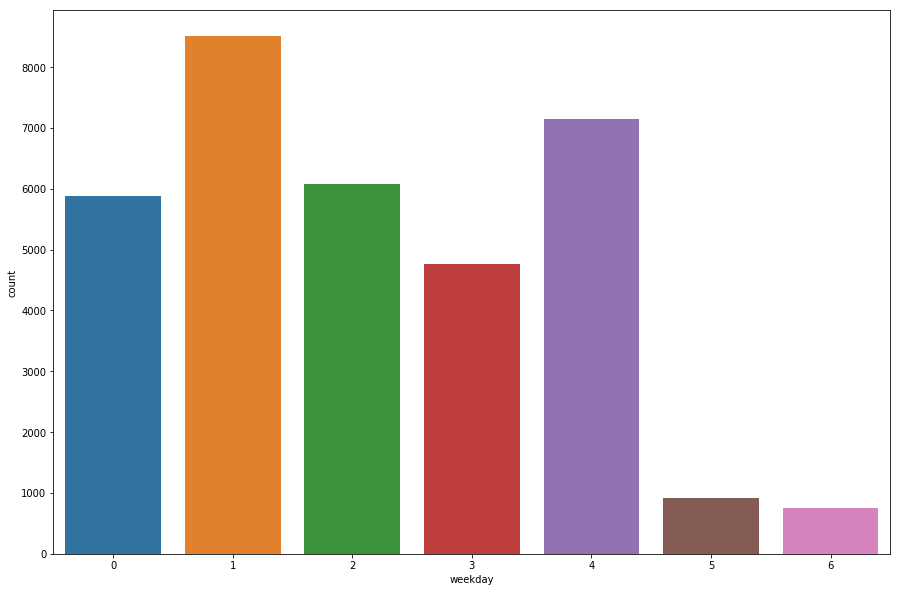

In [34]:
data = graph_train[(graph_train['year_month'] == '201311') & (graph_train['target'] == 0)]
plt.figure(figsize=(15,10))
sns.countplot(x='weekday', data=data);

In [41]:
graph_train = graph_train[graph_train['time1'].apply(lambda date: 
                                                          date >= pd.to_datetime('20131101', format='%Y%m%d', errors='ignore'))]

In [42]:
graph_train['year_month'].value_counts()

201403    56250
201402    55563
201401    35869
201311    34493
201404    31204
201312    16552
Name: year_month, dtype: int64

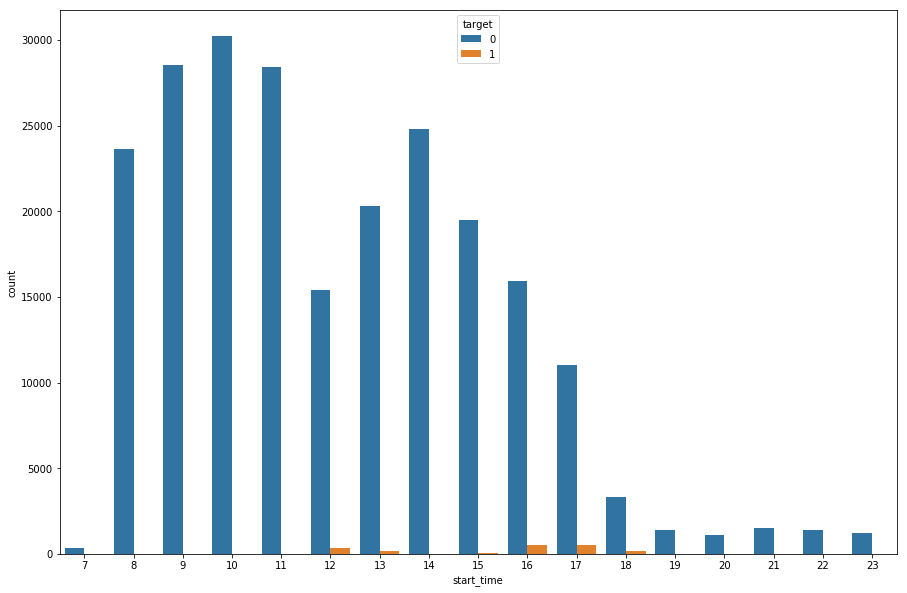

In [43]:
plt.figure(figsize=(15,10))
sns.countplot(x='start_time', hue='target', data=graph_train);

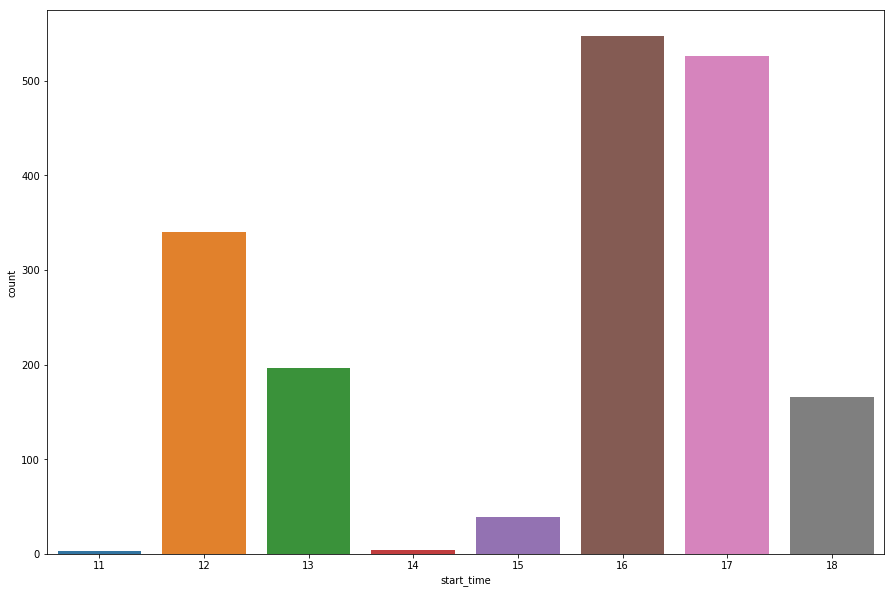

In [44]:
plt.figure(figsize=(15,10))
sns.countplot(x='start_time', data=graph_train[graph_train['target'] == 1]);

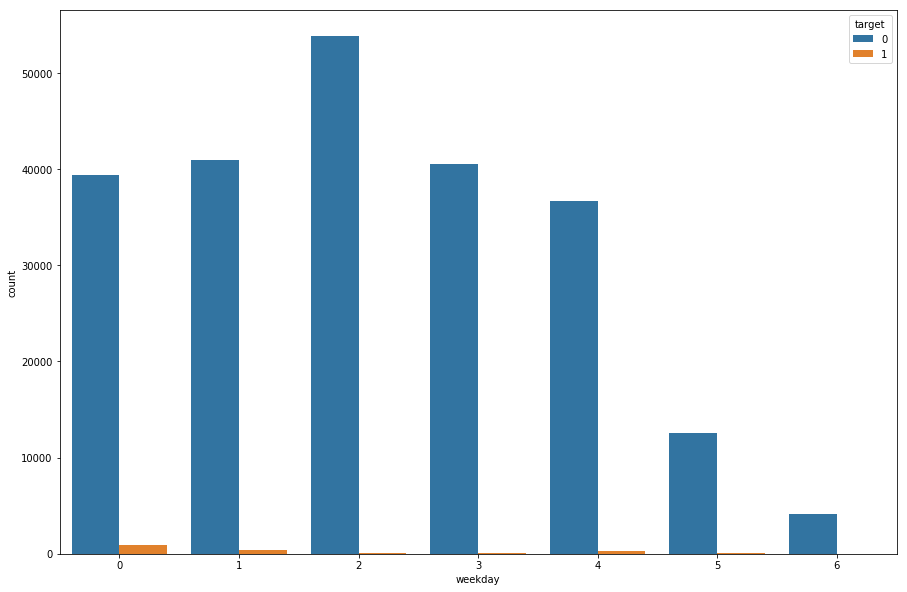

In [45]:
plt.figure(figsize=(15,10))
sns.countplot(x='weekday', hue='target', data=graph_train);

In [7]:
graph_train['year_month'] = [str(d.year) +str(d.month) if d.month >= 10 
                             else str(d.year) + '0' + str(d.month) for d in graph_train['time1']]

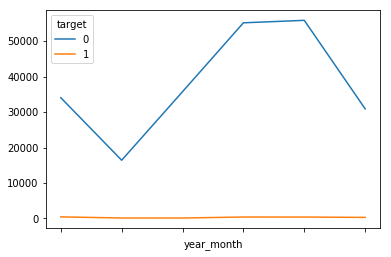

In [46]:
graph_train.pivot_table(index='year_month', values='site1', 
                     aggfunc='count', columns='target').plot();

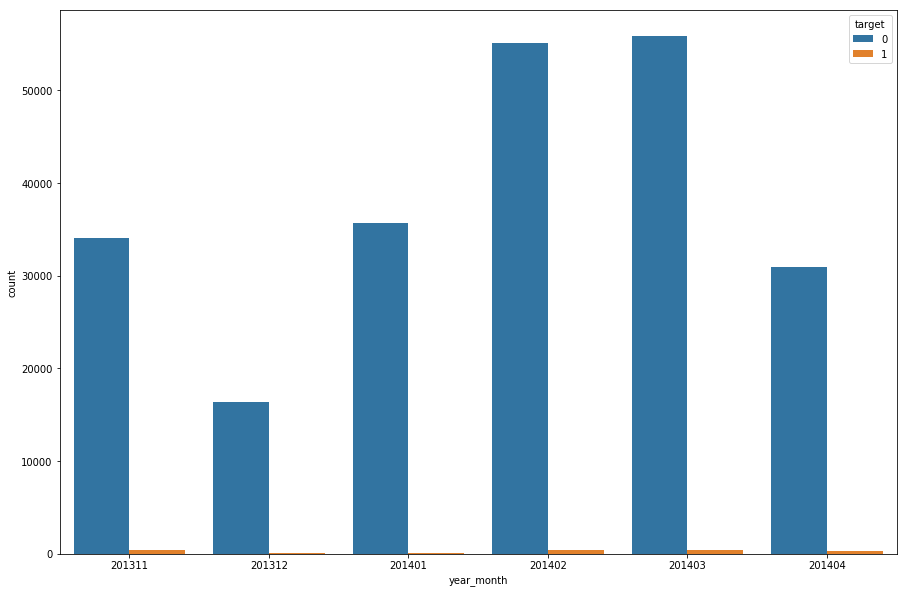

In [47]:
plt.figure(figsize=(15,10))
sns.countplot(x='year_month', hue='target', data=graph_train);

In [48]:
graph_train[graph_train['target'] == 1]['year_month'].value_counts()

201311    446
201402    410
201403    400
201404    302
201312    134
201401    129
Name: year_month, dtype: int64

In [23]:
graph_test = X_test.copy()
graph_test['start_time'] = [d.hour for d in graph_test['time1']]
graph_test['year_month'] = [str(d.year) +str(d.month) if d.month >= 10 
                        else str(d.year) + '0' + str(d.month) for d in graph_test['time1']]

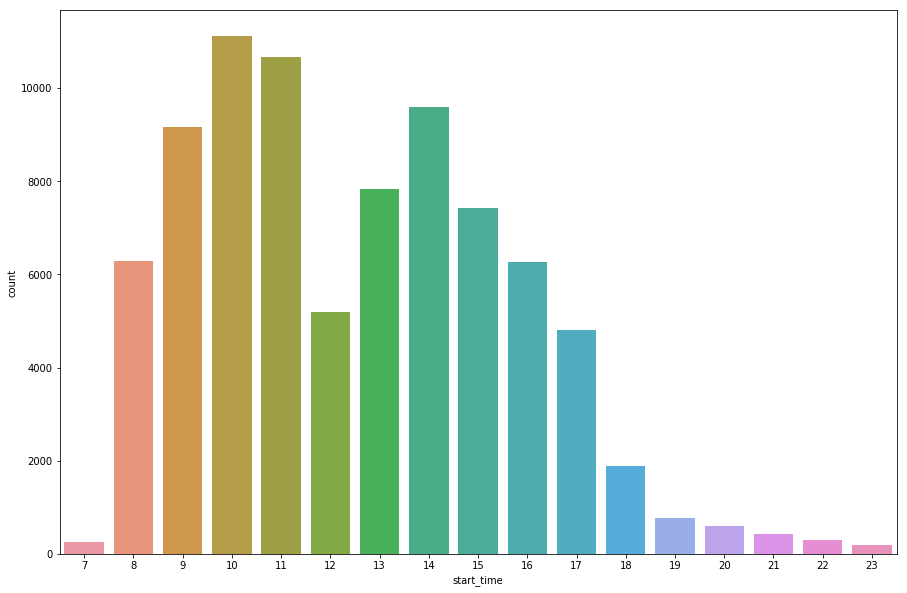

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(x='start_time', data=graph_test);

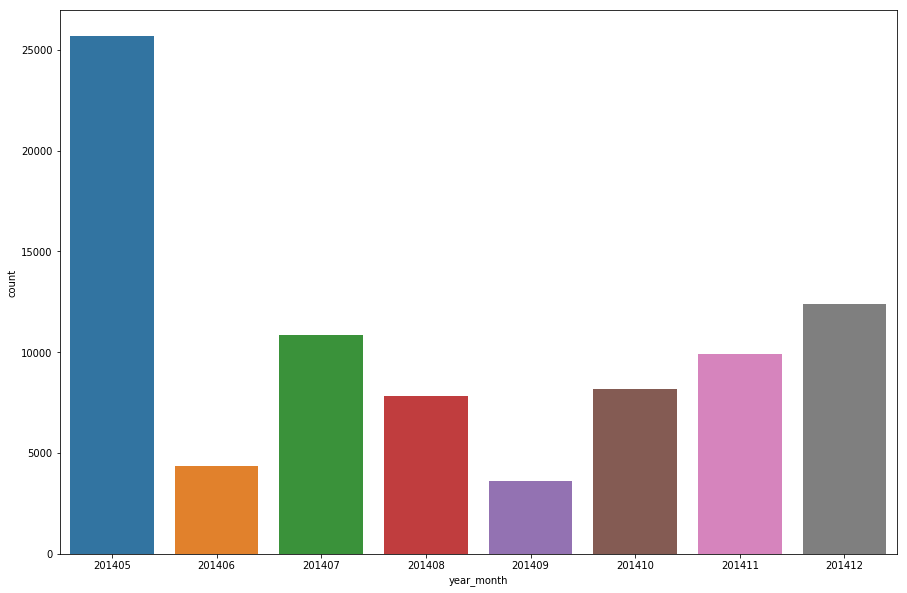

In [12]:
plt.figure(figsize=(15,10))
sns.countplot(x='year_month', data=graph_test);

In [49]:
site_dict = dict([(v, k) for (k, v) in site_dict.items()])
X_train, y_train = graph_train.drop('target', axis=1), graph_train['target']
X_test = test_df.copy()

for i in sites:
    X_train[i] = X_train[i].map(site_dict)
    X_test[i] = X_test[i].map(site_dict)

In [50]:
X_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time7,site8,time8,site9,time9,site10,time10,start_time,weekday,year_month
session_id,,,,,,,,,,,,,,,,,,,,,
168447,www-fourier.ujf-grenoble.fr,2013-11-12 08:04:19,security.debian.org,2013-11-12 08:04:19,backports.debian.org,2013-11-12 08:04:19,security.debian.org,2013-11-12 08:04:20,security.debian.org,2013-11-12 08:06:16,...,2013-11-12 08:06:17,backports.debian.org,2013-11-12 08:06:17,backports.debian.org,2013-11-12 08:06:18,www-fourier.ujf-grenoble.fr,2013-11-12 08:15:30,8,1,201311
141689,apis.google.com,2013-11-12 08:04:30,id.google.fr,2013-11-12 08:04:31,safebrowsing.clients.google.com,2013-11-12 08:05:23,safebrowsing-cache.google.com,2013-11-12 08:05:23,safebrowsing-cache.google.com,2013-11-12 08:05:24,...,2013-11-12 08:05:42,ocsp.thawte.com,2013-11-12 08:06:53,sb-ssl.google.com,2013-11-12 08:08:17,www.google.fr,2013-11-12 08:26:46,8,1,201311
6214,javadl-esd-secure.oracle.com,2013-11-12 08:05:56,ad.foxitsoftware.com,2013-11-12 08:35:43,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,8,1,201311
35728,armmf.adobe.com,2013-11-12 08:06:39,armmf.adobe.com,2013-11-12 08:06:41,www.bing.com,2013-11-12 08:17:08,www.bing.com,2013-11-12 08:17:09,cms.abmr.net,2013-11-12 08:17:10,...,2013-11-12 08:17:11,login.live.com,2013-11-12 08:17:11,www.bing.com,2013-11-12 08:17:12,ssl.bing.com,2013-11-12 08:17:12,8,1,201311
243069,ocsp.digicert.com,2013-11-12 08:06:45,www.squid-cache.org,2013-11-12 08:16:18,www.google.com,2013-11-12 08:16:26,clients1.google.com,2013-11-12 08:16:27,www.google.com,2013-11-12 08:16:30,...,2013-11-12 08:16:32,bits.wikimedia.org,2013-11-12 08:16:32,www.google.com,2013-11-12 08:16:32,meta.wikimedia.org,2013-11-12 08:16:33,8,1,201311


In [51]:
X_train['sites'] = X_train['site1']
X_test['sites'] = X_test['site1']
for i in sites[1:]:
    X_train['sites'] += ' ' + X_train[i].fillna('')
    X_test['sites'] += ' ' + X_test[i].fillna('')

In [52]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)

X_train_vect = vectorizer.fit_transform(X_train['sites'])
X_test_vect = vectorizer.transform(X_test['sites'])

In [53]:
logit = LogisticRegression(C=1, random_state=17)
time_split = TimeSeriesSplit(n_splits=10)

In [54]:
%%time
score = cross_val_score(estimator=logit, X=X_train_vect, y=y_train, cv=time_split, scoring='roc_auc')

Wall time: 1min 11s


In [55]:
score, score.mean()

(array([0.55716677, 0.84550099, 0.8859434 , 0.86637988, 0.78263317,
        0.92942938, 0.83687057, 0.87925407, 0.91789336, 0.93594506]),
 0.8437016637597745)

In [56]:
def add_time_features(df):
    X = df[['time1']]
    X['start_time'] = [d.hour for d in X['time1']]
    X['morning'] = [1 if 7 <= d <= 11 else 0 for d in X.start_time]
    X['day'] = [1 if 12 <= d <= 18 else 0 for d in X.start_time]
    X['evening'] = [1 if 19 <= d <= 23 else 0 for d in X.start_time]
    X['danger_time'] = [1 if 9 <= d <= 18 else 0 for d in X.start_time]
    X['weekday'] = [d.weekday() for d in X['time1']]
    features = ['morning', 'day', 'evening']
    X = pd.get_dummies(X, columns=['start_time', 'danger_time', 'weekday'])
    X = X.drop('time1', axis=1)
    
    return X

In [57]:
%%time
X_train_add = add_time_features(X_train.fillna(0))
X_test_add = add_time_features(X_test.fillna(0))

Wall time: 3min 17s


In [58]:
X_train_new = hstack([X_train_vect, X_train_add])
X_test_new = hstack([X_test_vect, X_test_add])

In [ ]:
%%time
score = cross_val_score(estimator=logit, X=X_train_new, y=y_train, cv=time_split, scoring='roc_auc')

In [ ]:
score, score.mean()

In [33]:
logit.fit(X_train_new, y_train)

LogisticRegression(C=12.915, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
test_pred = logit.predict_proba(X_test_new)[:, 1]

In [13]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [14]:
%%time
logit_grid_searcher.fit(X_train_new, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 29.6min finished


Wall time: 30min 36s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [15]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9063002102819764, {'C': 12.915496650148826})

In [16]:
test_pred = logit_grid_searcher.predict_proba(X_test_new)[:, 1]

In [17]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [35]:
write_to_submission_file(test_pred, "alice.csv")